<a href="https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/stablePeriodicPatterns/topk/TSPIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Stable Periodic Frequent patterns in Temporal Databases using TSPIN

This tutorial has two parts. In the first part, we describe the basic approach to find Stable Periodic Frequent patterns in a Temporal database using the TSPIN algorithm. In the final part, we describe an advanced approach, where we evaluate the TSPIN algorithm on a dataset at different K threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

File ‘Temporal_T10I4D100K.csv’ already there; not retrieving.



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Stable Periodic Frequent patterns using TSPIN

### Step 1: Understanding the statistics of a database to choose an appropriate k  value.

In [4]:
#import the class file
import PAMI.extras.dbStats.TemporalDatabase as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.TemporalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

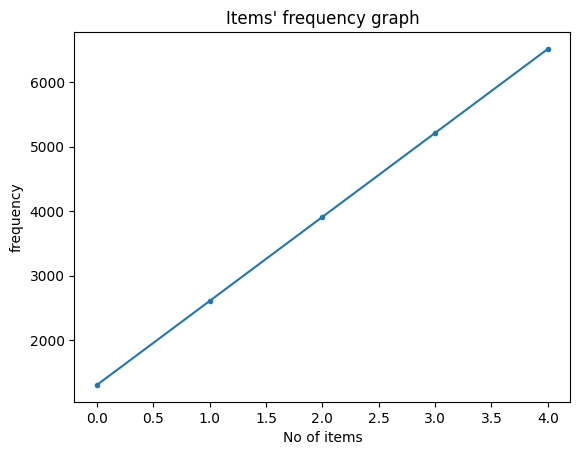

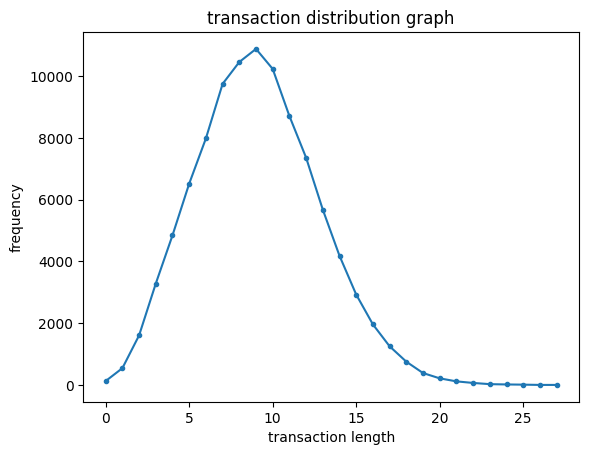

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _k_ value of 100 (in count). We can increase or decrease the _k_ based on the number of patterns being generated.

In [6]:
k = 100  #Users can also specify this constraint between 0 to 1.
maxmunPeriodCount = 5000 #Users can also specify different maxmunPeriodCount.
maxLaValue = 1000 #Users can also specify different maxLaValue.
seperator='\t'

### Step 4: Mining Stable Periodic Frequent patterns using TSPIN

In [7]:
from PAMI.stablePeriodicFrequentPattern.topK import TSPIN as alg #import the algorithm

obj = alg.TSPIN(inputFile, k, maxmunPeriodCount, maxLaValue, seperator)  #initialize
obj.mine()            #start the mining process

obj.save('stablePeriodicFrequentPatternsAtK100.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 
Total No of patterns: 394
Runtime: 22.128568410873413
Memory (RSS): 509935616
Memory (USS): 486895616


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [8]:
!head 'stablePeriodicFrequentPatternsAtK100.txt'

484 :969:4752 
96 :974:3825 
277 :982:4008 
432 :983:3516 
160 :986:3645 
395 :989:3908 
608 :997:2562 
7 :997:2648 
912 :1008:3739 
511 :1014:2819 


The storage format is: _stablePeriodicFrequentPattern:support_
***

## Part 2: Evaluating the TSPIN algorithm on a dataset at different k values


### Step 1: Import the libraries and specify the input parameters

In [9]:
#Import the libraries
from PAMI.stablePeriodicFrequentPattern.topK import TSPIN as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
separator='\t'
maxmunPeriodCount = 5000
maxLaValue = 1000
kList = [100, 200, 300, 400, 500]
#k can also specified between 0 to 1. E.g., kList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of TSPIN

In [10]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'maximumPeriodCount', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of TSPIN algorithm

### Step 3: Execute the algorithm at different minSup values

In [11]:
for minSupCount in kList:
    obj = alg.TSPIN(iFile=inputFile, k=minSupCount, maxPer = maxmunPeriodCount, maxLa = maxLaValue, sep = separator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['TSPIN', minSupCount, maxmunPeriodCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 
Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 
Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 
Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 
Top-K Stable Periodic patterns were generated successfully using TSPIN algorithm 


### Step 4: Print the Result

In [12]:
print(result)

  algorithm  minSup  maximumPeriodCount  patterns     runtime     memory
0     TSPIN     100                5000     43531  457.651955  484859904
1     TSPIN     200                5000     43531  476.647002  485982208
2     TSPIN     300                5000     43531  479.507844  487383040
3     TSPIN     400                5000     43531  496.476079  487313408
4     TSPIN     500                5000     43531  474.265221  487452672


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

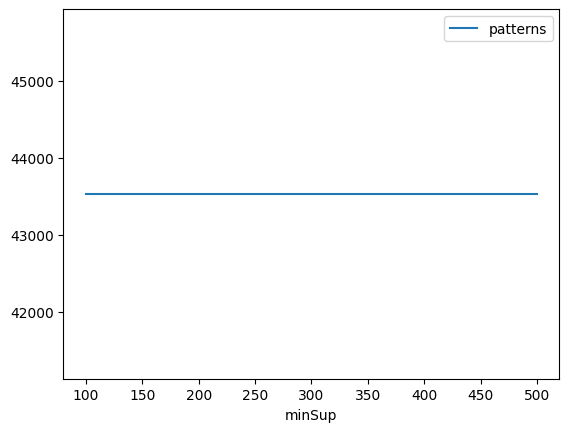

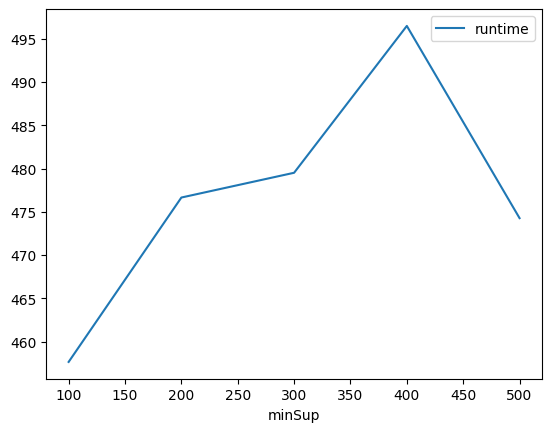

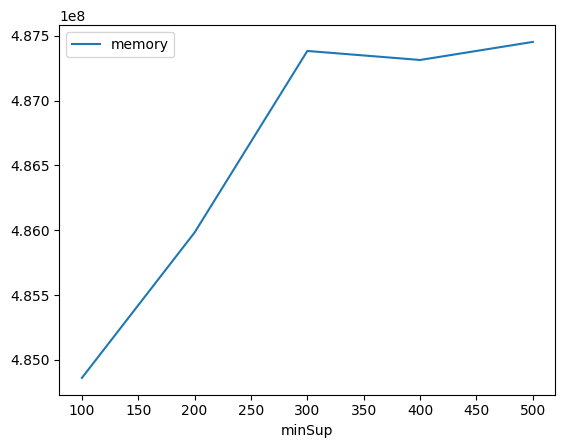

In [13]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib